## Conformally invariant dissipative relativistic fluid

Here we solve numerically the equations deduced in \ref{xxx}

In [1]:
using OrdinaryDiffEq
using Plots
using FileIO

In [2]:
#mkdir("Resultados/Soluciones")

We add the modules needed for the computation:

    choques_utils are the mp5 and kt shock capturing schemes
    
    Flux_functions_ext contain the fluxes and sources for the system
    
    inversion_ext the inversion between conservative and fluid quantities
    
The ext means that we are considering a vector of 10 variables, 5 conservative and 5 fluid variables. The fluid variables are evolved with a zero time derivative, and are updated inside the evolution equation using the inversion function.

In [3]:
include("inversion_ext.jl")
include("choques_utils.jl") # all functions needed for evolution
include("Flux_function_ext.jl")

 Activating environment at `~/Julia/Fluidos_Conformes/Conf_Fluids/Project.toml`
   Updating registry at `~/.julia/registries/General`
######################################################################### 100.0%
  Resolving package versions...
No Changes to `~/Julia/Fluidos_Conformes/Conf_Fluids/Project.toml`
No Changes to `~/Julia/Fluidos_Conformes/Conf_Fluids/Manifest.toml`


Speed_max (generic function with 1 method)

Some set of parameters:

This have all $v_0(x) = flu_0[i,2] = 0.1 + 0.1 * (x[i] - x0)^4 * (x[i] - x1)^4 / (x1-x0)^8 * 250 $ in the interval $[0.4,0.6]$

$\mu = flu_0[i,1] = -1.$


n_0 χ = [- 1.; 0.; - 1.] Speed = 1 dt/dx = 0.1 T = 2    **This is Euler**

p_1 χ = [- 1.; - 2.; - 10.] Speed = 1 dt/dx = 0.1

p_2 χ = [- 1.; - 2.; - 10.] Speed = 1 dt/dx = 0.01

p_3 χ = [- 1.; - 2.; - 10.] Speed = 10 dt/dx = 0.01

p_4 χ = [- 1.; - 0.5; - 200.] Speed = 1 dt/dx = 0.1

p_5 χ = [- 1.; -0.5; - 5.] Speed = 1 dt/dx = 0.1 (con fuente) T = 2


We now change to a zero background speed and put the pulse near zero so that they don't cross at bad places.

n0_0 χ = [- 1.; 0.; - 1.] Speed = 1 dt/dx = 0.1 T = 2    **This is Euler**

In [142]:
sod = false    # No implementado
sod_E = false  # No implementado
speed_pulse = false # a simple speed pulse (no muy interesante pues hay pulsos en las dos direcciones)
speed_pulse_E = false # Euler version
temperature_pulse = false # a simple temperature μ pulse (no implementado)
temperature_pulse_E = false # Euler version (no implementado)
small_pulse_to_the_right = false # low velocity perturbation pulse in just one direction
small_pulse_to_the_right_E = false # Euler version (this are used to measure the propagation speeds)
big_pulse_to_the_right = false # Choques (la velocidad no es muy alta todavía)
big_pulse_to_the_right_E = false
# poner a continuación la que uno quiere usar con un true (así todos los demás quedan en false)
big_pulse_to_the_right_E = true

true

In [143]:
if speed_pulse_E
    name = "spee_pulse_E" 
    L=2.4 # Length of the integration region
    M=600 # number of space-points in the discretization
    t=2 # final time
    dx = L/M
    dt = 0.1 * dx # this depends on the maximal propagation speed
    tol = 10^(-10) # error tolerance in inversion function (Newton-Raphson)
    iter_max = 40  # maximum number of NR iterations

    χ = [- 1.0; - 0.; - 5.0] # the equation parameters 
    ξ = (49.735919716217296, 16.578639905405765) # (λ, κ) dissipative parameters
       1


elseif speed_pulse
    name = "speed_pulse" 
    L=2.4 # Length of the integration region
    M=600 # number of space-points in the discretization
    t=2. # final time
    dx = L/M
    dt = 0.1 * dx # this depends on the maximal propagation speed
    tol = 10^(-10) # error tolerance in inversion function (Newton-Raphson)
    iter_max = 40  # maximum number of NR iterations

    χ = [- 1.0; - 0.1; - 5.0] # the equation parameters 
    ξ = (49.735919716217296, 16.578639905405765) # (λ, κ) dissipative parameters

    
elseif sod
    name = "sod" 
    L=1. # Length of the integration region
    M=400 # number of space-points in the discretization
    t=2. # final time
    dx = L/M
    dt = 0.1 * dx # this depends on the maximal propagation speed
    tol = 10^(-10) # error tolerance in inversion function (Newton-Raphson)
    iter_max = 40  # maximum number of NR iterations

    χ = [- 1.0; - 0.1; - 5.0] # the equation parameters 
    ξ = (49.735919716217296, 16.578639905405765) # (λ, κ) dissipative parameters

    
elseif sod_E
    name = "sod_E" 
    L=1. # Length of the integration region
    M=400 # number of space-points in the discretization
    t=2. # final time
    dx = L/M
    dt = 0.1 * dx # this depends on the maximal propagation speed
    tol = 10^(-10) # error tolerance in inversion function (Newton-Raphson)
    iter_max = 40  # maximum number of NR iterations

    χ = [- 1.0; - 0.1; - 5.0] # the equation parameters 
    ξ = (49.735919716217296, 16.578639905405765) # (λ, κ) dissipative parameters
    
elseif  small_pulse_to_the_right_E
    name = "small_right_p_E" 
    L=4. # Length of the integration region
    M=600 # number of space-points in the discretization
    t=4. # final time
    dx = L/M
    dt = 0.1 * dx # this depends on the maximal propagation speed
    tol = 10^(-10) # error tolerance in inversion function (Newton-Raphson)
    iter_max = 40  # maximum number of NR iterations

    χ = [- 1.0; - 0.0; - 10.0] # the equation parameters 
    ξ = (49.735919716217296, 16.578639905405765) # (λ, κ) dissipative parameters
    
elseif  small_pulse_to_the_right
    name = "small_right_p" 
    L=4. # Length of the integration region
    M=600 # number of space-points in the discretization
    t=4. # final time
    dx = L/M
    dt = 0.1 * dx # this depends on the maximal propagation speed
    tol = 10^(-10) # error tolerance in inversion function (Newton-Raphson)
    iter_max = 40  # maximum number of NR iterations

    χ = [- 1.0; - 0.5; - 10.0] # the equation parameters 
    ξ = (49.735919716217296, 16.578639905405765) # (λ, κ) dissipative parameters
    
elseif  big_pulse_to_the_right_E
    name = "big_right_p_E" 
    L=4. # Length of the integration region
    M=600 # number of space-points in the discretization
    t=4. # final time
    dx = L/M
    dt = 0.1 * dx # this depends on the maximal propagation speed
    tol = 10^(-10) # error tolerance in inversion function (Newton-Raphson)
    iter_max = 40  # maximum number of NR iterations

    χ = [- 1.0; - 0.0; - 10.0] # the equation parameters 
    ξ = (49.735919716217296, 16.578639905405765) # (λ, κ) dissipative parameters
    
elseif  big_pulse_to_the_right
    name = "big_right_p" 
    L=4. # Length of the integration region
    M=600 # number of space-points in the discretization
    t=4. # final time
    dx = L/M
    dt = 0.1 * dx # this depends on the maximal propagation speed
    tol = 10^(-10) # error tolerance in inversion function (Newton-Raphson)
    iter_max = 400  # maximum number of NR iterations
    
    χ = [- 1.0; - 0.5; - 10.0] # the equation parameters 
    ξ = (49.735919716217296, 16.578639905405765) # (λ, κ) dissipative parameters
    
end

U=10 # number of fields (double the number of fields, one for fluid and the other for conservative quantities)
u_i=zeros(M*U) # flux variables for the initial data (these are used for the flux function)
du=zeros(M*U) # for the rhs
x = zeros(M) # the coordinates
    
par_eq = (χ, ξ) # parameters to use on the equations
par_inv = (χ, tol, iter_max, U, M) # parameters for the inversion
    

([-1.0, -0.0, -10.0], 1.0000000000000006e-10, 40, 10, 600)

In [144]:
#full list of parameters for the evolution function
if χ[1] < 0
    par = (par_eq, par_inv, 1. /dx, U, M, Flux, Speed_max, Is_dummy, c_to_f!) 
else
    par = (par_eq, par_inv, 1. /dx, U, M, Flux, Speed_max, Is_dummy, c_to_f!)
end

(([-1.0, -0.0, -10.0], (49.735919716217296, 16.578639905405765)), ([-1.0, -0.0, -10.0], 1.0000000000000006e-10, 40, 10, 600), 150.0, 10, 600, Flux, Speed_max, Is_dummy, c_to_f!)

In [145]:
# the initial data
# we give initial data in the fluid variables and then transform to conservatives

if speed_pulse || speed_pulse_E
    
    u_i=zeros(M*U)
    con_0 = view(reshape(u_i,(M,U)),:,1:U÷2)
    flu_0 = view(reshape(u_i,(M,U)),:,U÷2+1:U)
    x0 = 0.0; x1 = 0.2 #x0 = 0.4; x1 = 0.6
    v0 = 0.0; δv = 0.1 

    for i in 1:M
        x[i] = dx*(i-1)
        if x[i] > x0 && x[i] < x1
            flu_0[i,2] = v0 + δv *(x[i] - x0)^4 * (x[i] - x1)^4 / (x1-x0)^8 * 250                   #Sz
            flu_0[i,1] = -0.0 # * sin(pi*(x[i] - x0)/(x1-x0))^4 * sin(2*pi*(x[i] - x0)/(x1-x0))     #By
        else
            flu_0[i,2] = v0
        end
    
        flu_0[i,1] = -1.   #
    #flu_0[i,2] = flu_0[i,2] + 0.1  # v
    
    end
f_to_c!(u_i, (χ, U, M)); # populate the conservative variables from the fluid ones
end

if small_pulse_to_the_right_E || small_pulse_to_the_right

    u_i=zeros(M*U)
    con_0 = view(reshape(u_i,(M,U)),:,1:U÷2)
    flu_0 = view(reshape(u_i,(M,U)),:,U÷2+1:U)

    e0 = 6.; δe = 0.1
    x0 = 0.; x1 = 0.2
    λ = 1. /sqrt(3.)
    for i in 1:M
        x[i] = dx*(i-1)
        if x[i] > x0 && x[i] < x1
            con_0[i,1] = e0 + δe *(x[i] - x0)^4 * (x[i] - x1)^4 / (x1-x0)^8 * 250                   #Sz
            con_0[i,2] = λ*(con_0[i,1] - e0)
        else
            con_0[i,1] = e0
            con_0[i,2] = 0.
        end
            flu_0[i,1] = -1.
    end
    par_inv = (χ, tol, 10000, U, M)
    u_i = c_to_f!(u_i,par_inv);
    reshape(u_i,U,M)
end

if big_pulse_to_the_right_E || big_pulse_to_the_right
    
    u_i=zeros(M*U)    
    con_0 = view(reshape(u_i,(M,U)),:,1:U÷2)
    flu_0 = view(reshape(u_i,(M,U)),:,U÷2+1:U)

    e0 = 6.; δe = 4.0
    x0 = 0.; x1 = 0.2
    λ = 1. /sqrt(3.)
    for i in 1:M
        x[i] = dx*(i-1)
        if x[i] > x0 && x[i] < x1
            con_0[i,1] = e0 + δe *(x[i] - x0)^4 * (x[i] - x1)^4 / (x1-x0)^8 * 250                   #Sz
            con_0[i,2] = λ*(con_0[i,1] - e0)
        else
            con_0[i,1] = e0
            con_0[i,2] = 0.
        end
            flu_0[i,1] = -sqrt(con_0[i,1])/6
    end
    if big_pulse_to_the_right
        χ = [- 1.0; - 0.; - 10.0] #primero nos aproximamos a la solución con χ₁=0
        par_inv = (χ, tol, 1000, U, M)
        u_i = c_to_f!(u_i,par_inv);
        χ = [- 1.0; - 0.; - 10.0] #luego buscamos la buena con la semilla anterior
        par_inv = (χ, tol, 10000, U, M)
        u_i = c_to_f!(u_i,par_inv);
        #check!
        f_to_c!(u_i,(χ,U,M)) - u_i
    end
        reshape(u_i,U,M)
end

10×600 Array{Float64,2}:
 6.0      8.43865  8.43865  6.0  6.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 6.00108  8.90814  7.94481  6.0  6.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 6.01499  9.31776  7.46245  6.0  6.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 6.06561  9.63579  7.02408  6.0  6.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 6.1783   9.83727  6.65536  6.0  6.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 6.37211  9.90625  6.37211  6.0  6.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 6.65536  9.83727  6.1783   6.0  6.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 7.02408  9.63579  6.06561  6.0  6.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 7.46245  9.31776  6.01499  6.0  6.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 7.94481  8.90814  6.00108  6.0  6.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

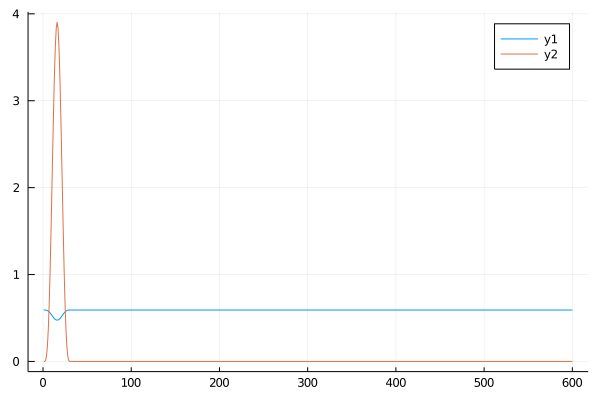

In [146]:
plot(flu_0[:,1] .+1) #plot(flu_0[:,1] .- 6)
plot!(con_0[:,1] .-6)

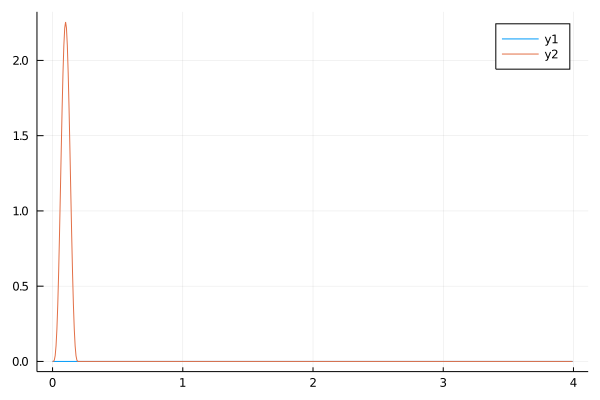

In [147]:
plot(x,flu_0[:,2])
plot!(x,con_0[:,2])

In [148]:
function evolution(du,u,par,t)
    # this is the function that is taken by the time-integrator
    par_eq, par_inv, h_1, U, M, Flux, Speed_max, Source, c_to_f = par
    χ, ζ = par_eq
    
    #p_direct = (χ, U, M) #these are the parameters for direct
    #c_to_f_direct!(u,p_direct)
    c_to_f!(u,par_inv)
    
    par_mp5 = (h_1, U, M, χ, ζ, Flux, Speed_max, Source)
    for j ∈ 1:M
        mp5(du,u,par_mp5,j)
    end
    return du[:]
end

evolution (generic function with 1 method)

In [149]:
prob = ODEProblem(evolution,u_i,(0.0,t),par);

In [150]:
#sol = solve(prob_euler_direct,SSPRK33(),dt=dt,saveat=0.01*t); # This, I think, is a TVD method
sol = solve(prob,SSPRK33(),dt=dt,saveat=0.01*t); 
#sol = solve(prob,SSPRK33(),dt=dt,save_everystep=false) # to get just the end values
#sol = solve(prob,RK4(),dt=dt);

In [151]:
save("Resultados/Soluciones/$name.jld2", Dict("$name" => sol))


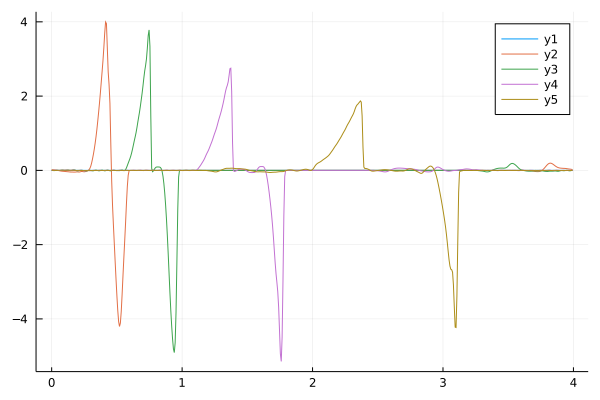

In [138]:
#sol(t) = sol_nr_p5(t) - sol_nr_n0(t)
#sol(t) = sol_n0_0(t)
field = 5
plot(x,reshape(sol(0.),(M,U))[:,field])
plot!(x,reshape(sol(t/8),(M,U))[:,field])
plot!(x,reshape(sol(t/4),(M,U))[:,field])
plot!(x,reshape(sol(t/2),(M,U))[:,field])
plot!(x,reshape(sol(t/1.1),(M,U))[:,field])

┌ Info: Saved animation to 
│   fn = /Users/reula/Julia/Fluidos_Conformes/Resultados/Movies/big_right_p.gif
└ @ Plots /Users/reula/.julia/packages/Plots/SjqWU/src/animation.jl:104


Plots.AnimatedGif("/Users/reula/Julia/Fluidos_Conformes/Resultados/Movies/big_right_p.gif")
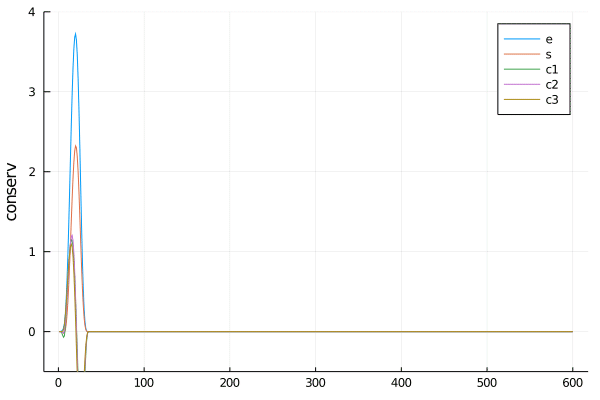

In [139]:
##### ssol(t) = sol_dir_n0(t)
ssol(t) = sol(t)
shift = 0# U÷2 # 0 is conserv otherwise is fluid
anim = @animate for i ∈ 1:100
    plot(reshape(ssol(t*0.01*i),(M,U))[:,shift+1] .- 6.0,label="e", yaxis = ("conserv", (-0.5,4)))
    plot!(reshape(ssol(t*0.01*i),(M,U))[:,shift+2] .- 0.,label="s")
    plot!(reshape(ssol(t*0.01*i),(M,U))[:,shift+3],label="c1")
    plot!(reshape(ssol(t*0.01*i),(M,U))[:,shift+4],label="c2")
    plot!(reshape(ssol(t*0.01*i),(M,U))[:,shift+5],label="c3")
end

gif(anim, "Resultados/Movies/$name.gif", fps = 10)

┌ Info: Saved animation to 
│   fn = /Users/reula/Julia/Fluidos_Conformes/Resultados/Movies/big_right_p_E.gif
└ @ Plots /Users/reula/.julia/packages/Plots/SjqWU/src/animation.jl:104


Plots.AnimatedGif("/Users/reula/Julia/Fluidos_Conformes/Resultados/Movies/big_right_p_E.gif")
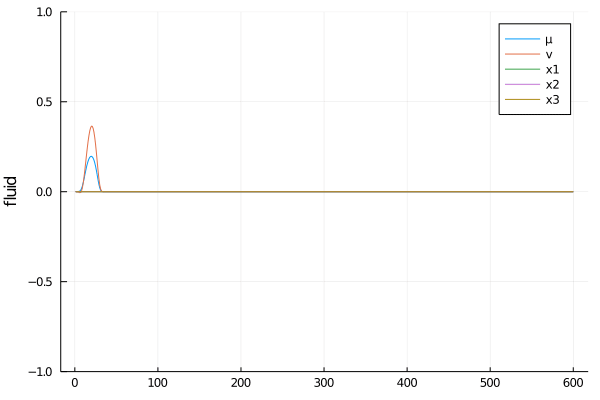

In [152]:
#ssol(t) = sol_dir_n0(t)
ssol(t) = sol(t)
shift = U÷2 # 0 is conserv otherwise is fluid
anim = @animate for i ∈ 1:100
    plot(reshape(ssol(t*0.01*i),(M,U))[:,shift+1] .+ 1,label="μ", yaxis = ("fluid", (-1,1)))
    plot!(2 .* (reshape(ssol(t*0.01*i),(M,U))[:,shift+2]) ,label="v")
    plot!(reshape(ssol(t*0.01*i),(M,U))[:,shift+3].*50 ,label="x1")
    plot!(reshape(ssol(t*0.01*i),(M,U))[:,shift+4].*50 ,label="x2")
    plot!(reshape(ssol(t*0.01*i),(M,U))[:,shift+5].*50 ,label="x3")
end

gif(anim, "Resultados/Movies/$name.gif", fps = 10)

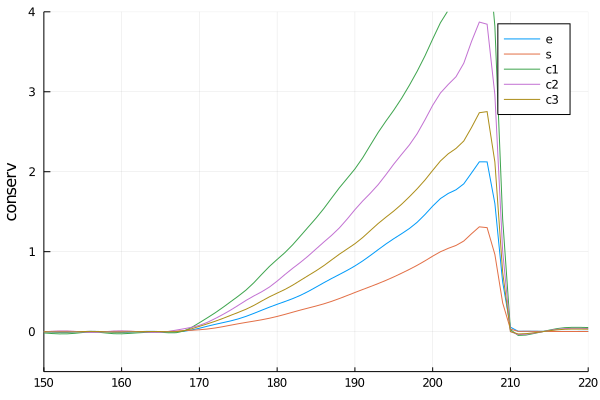

In [141]:
##### ssol(t) = sol_dir_n0(t)
ssol(t) = sol(t)
t = 2
shift = 0# U÷2 # 0 is conserv otherwise is fluid
    plot(reshape(ssol(t),(M,U))[:,shift+1] .- 6.0,label="e", xlim = (150,220), yaxis = ("conserv", (-0.5,4)))
    plot!(reshape(ssol(t),(M,U))[:,shift+2] .- 0.,label="s")
    plot!(reshape(ssol(t),(M,U))[:,shift+3],label="c1")
    plot!(reshape(ssol(t),(M,U))[:,shift+4],label="c2")
    plot!(reshape(ssol(t),(M,U))[:,shift+5],label="c3")

#### Aquí siguen celdas que solo importan para pruebas.

## Euler equations

We recuperate Euler's equations setting $\chi_1 = 0$ and the dissipative variables to zero. That way the systems decouple. And we get: (the notation here is a bit misleading,
here $\rho \approx e$ Different from $E = (\rho + p) = 4/3 \rho$, since $p = \frac{1}{3}\rho$ and so $s = Ev = 4/3 e v$

$F_e = \frac{4}{3}ργ^2v = s$

$F_s = \frac{4}{3}ρ(γ^2v^2 + \frac{1}{4}) = \frac{1}{3}ργ^2(4 v^2 + \frac{1}{\gamma^2} = 
\frac{1}{3}ργ^2(3v^2 + 1) $

$e = \frac{4}{3}ρ(γ^2 - \frac{1}{4}) = \frac{1}{3}ργ^2(4 - \frac{1}{\gamma^2}) = \frac{1}{3}ργ^2(3 + v^2)$

$s = \frac{4}{3}ργ^2v$

$4\frac{e}{s}v - (3 + v^2) = 0$

$v = 2\frac{e}{s} \pm \sqrt{4(\frac{e}{s})^2 -3}$

$v_- =  \frac{3}{2\frac{e}{s} + \sqrt{4(\frac{e}{s})^2 -3}} \approx \frac{3s}{4e}$


In [ ]:
function evolution_euler_direct(du,u,par,t) # here χ₁=0!
    # this is the function that is taken by the time-integrator
    par_eq, par_inv, h_1, U, M, Flux, Speed_max, Source, c_to_f = par
    χ = par_eq
    
    p_direct = (χ, U, M) #these are the parameters for direct
    c_to_f_direct!(u,p_direct)
    #c_to_f!(u,par_inv)
    
    par_mp5 = (h_1, U, M, χ, χ, Flux, Speed_max, Source)
    for j ∈ 1:M
        mp5(du,u,par_mp5,j)
    end
    return du[:]
end

In [ ]:

prob_euler_direct = ODEProblem(evolution_euler_direct,u_i,(0.0,t),par);

In [ ]:
#sol = sol_dir_n0;
dsol(t) = sol_nr_n0(t) - sol_dir_n0(t);
reshape(dsol(0.),(M,U))[:,1];

In [ ]:
field = 1
plot(reshape(sol_nr_n0(0.),(M,U))[:,field] .- reshape(sol_dir_n0(0.),(M,U))[:,field])
plot!(reshape(sol_nr_n0(t/8),(M,U))[:,field] .- reshape(sol_dir_n0(t/8),(M,U))[:,field])
plot!(reshape(sol_nr_n0(t/4),(M,U))[:,field] .- reshape(sol_dir_n0(t/4),(M,U))[:,field])
plot!(reshape(sol_nr_n0(t/2.1),(M,U))[:,field] .- reshape(sol_dir_n0(t/2.1),(M,U))[:,field])
#plot!(reshape(sol_nr_n0(t/1.1),(M,U))[:,field] .- reshape(sol_dir_n0(t/1.1),(M,U))[:,field])

In [ ]:
anim = @animate for i ∈ 1:100
    plot(reshape(dsol(t*0.01*i),(M,U))[:,1],label="e", yaxis = ("conserv", (-1e-7,1e-7)))
    plot!(reshape(dsol(t*0.01*i),(M,U))[:,2],label="s")
    plot!(reshape(dsol(t*0.01*i),(M,U))[:,3],label="c1")
    plot!(reshape(dsol(t*0.01*i),(M,U))[:,4],label="c2")
    plot!(reshape(dsol(t*0.01*i),(M,U))[:,5],label="c3")
end

gif(anim, "ff_n0_dif_anim_fps10.gif", fps = 10)

In [ ]:
anim = @animate for i ∈ 1:100
    plot(reshape(dsol(t*0.01*i),(M,U))[:,5+1],label="μ", yaxis = ("fluid", (-1e-8,1e-8)))
    plot!(reshape(dsol(t*0.01*i),(M,U))[:,5+2],label="v")
    plot!(reshape(dsol(t*0.01*i),(M,U))[:,5+3],label="X1")
    plot!(reshape(dsol(t*0.01*i),(M,U))[:,5+4],label="X2")
    plot!(reshape(dsol(t*0.01*i),(M,U))[:,5+5],label="X3")
end

gif(anim, "ff_n0_dif_anim_fps10.gif", fps = 10)